<a href="https://colab.research.google.com/github/fatuunreal/nlp-fatu-andi/blob/main/Klasifikasi_sms_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Membandingkan Algoritma Naive Bayes dan Random Forest dalam Klasifiksi Spam pada SMS

##BY: FATU RAHMAT (A11.2022.14831) ANDI LAKSONO (A11,2022.14839)
## PEMROSESAN BAHASA ALAMI BERBASIS TEKS A11.4617
       

## Load Library

In [26]:
!pip install wordcloud

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## load dataset

In [29]:
data = pd.read_csv('spam.csv')
data.head()

,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."


## EDA Exploratory Data Analysis
proses analisis data yang bertujuan untuk memahami karakteristik, pola, dan hubungan dalam data sebelum melakukan pemodelan lebih lanjut dalam Machine Learning

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2636 non-null   object
 1   Pesan     2636 non-null   object
dtypes: object(2)
memory usage: 41.3+ KB


In [31]:
data['Kategori'].unique()

array(['spam', 'ham'], dtype=object)

In [32]:
Kategori = {'spam':0, 'ham':1}

data['Kategori'] = data['Kategori'].map(Kategori)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2636 non-null   int64 
 1   Pesan     2636 non-null   object
dtypes: int64(1), object(1)
memory usage: 41.3+ KB


In [34]:
#mengubah nama kolom
data.rename(columns = {"Kategori": "label", "Pesan": "teks"}, inplace = True)

In [35]:
data.head()

,label,teks
0,0,Secara alami tak tertahankan identitas perusah...
1,0,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,0,Rumah -rumah baru yang luar biasa menjadi muda...
3,0,4 Permintaan Khusus Pencetakan Warna Informasi...
4,0,"Jangan punya uang, dapatkan CD perangkat lunak..."


### melihat distribusi label

<Axes: title={'center': 'Distribusi Label'}, xlabel='label'>

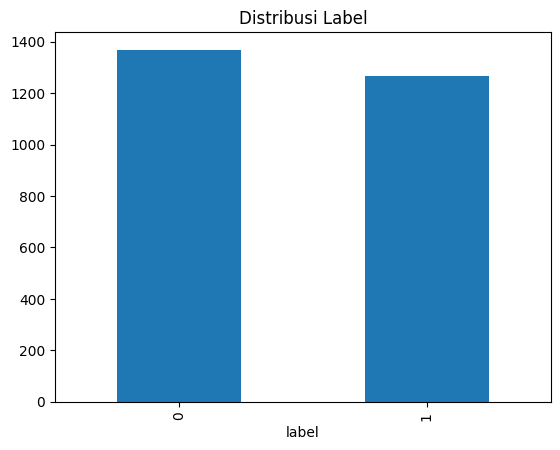

In [36]:
data['label'].value_counts().plot(kind='bar', title='Distribusi Label')

### Melihat kata yang sering muncul

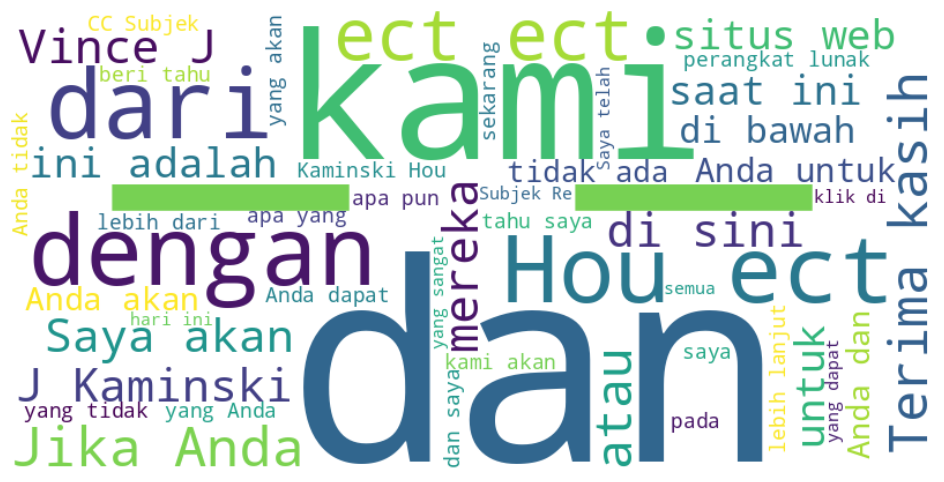

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text messages into a single string
all_text = ' '.join(data['teks'])

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=50
).generate(all_text)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Kondisi Outlier

<Axes: >

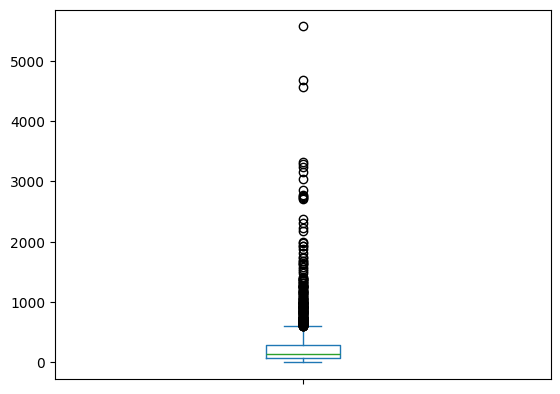

In [38]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in data['teks']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

## text preprocessing

In [39]:
# mengecek missing value
print(data.isnull().sum())


label    0
teks     0
dtype: int64


## case folding
mengubah tiap kata menjadi kecil, menghapus tanda baca atau angka

In [40]:
import re

# membuat ungsi untuk case folding
def casefolding(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[-+]?[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    return text

In [41]:
# membandingkan sebelum dan sesudah case folding
raw_sample = data['teks'].iloc[100]
case_folding = casefolding(raw_sample)

print('raw data\t : ', raw_sample)
print('case folding\t : ', case_folding)

raw data	 :  Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
case folding	 :  re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu    lebih baik dilengkapi daripada seorang pria dengan palu    apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan    datang ke sini dan lihat bagaimana     email net ini disponsori oleh thinkgeek selamat datang di geek heaven http   thinkgeek milis


## word normalization
translating atau membenahi kata

In [42]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0]
    if (key_norm['singkat'] == word).any()
    else word for word in text.split()
    ])

    text == str.lower(text)
    return text

In [43]:
# membandingkan before dan after word normalization

raw_data = data['teks'].iloc[100]
word_normal = text_normalize(case_folding)

print('raw data\t:', raw_data)
print('word normalize\t:', word_normal)

raw data	: Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
word normalize	: re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu lebih baik dilengkapi daripada seorang pria dengan palu apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan datang ke sini dan lihat bagaimana email net ini disponsori oleh thinkgeek selamat datang di geek heaven http thinkgeek milis


## filtering (stopword removal)
untuk mengurangi noise pada teks, mengurangi ukuran fitur dan meningkatkan akurasi

In [44]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [45]:
len (stopwords_ind)

758

In [46]:
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [47]:
# membuat fungsi stopword removal

# menambahkan kata kedalam stopwords
more_stopword = ['tsel', 'gb', 'rb', 'btw']
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_word(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)

In [48]:
raw_sample = data['teks'].iloc[100]
case_folding = casefolding(raw_sample)
stopwords_removal = remove_stop_word(case_folding)

print('raw data \t\t:', raw_data)
print('case folding \t\t:', case_folding)
print('stopword removal \t:', stopwords_removal)

raw data 		: Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
case folding 		: re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu    lebih baik dilengkapi daripada seorang pria dengan palu    apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan    datang ke sini dan lihat bagaimana     email net ini disponsori oleh thinkgeek selamat datang di geek heaven http   thinkgeek milis
stopword removal 	: re pil disetujui dokter lgw pria diberkahi palu

In [49]:
!pip -q install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.0 MB/s eta 0:00:00


## Stemming

In [50]:
# merubah kata menjadi kata dasar
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# membuat fungsi untuk stemming bahasa indonesia
def stemming(text):
    text = stemmer.stem(text)
    return text

In [51]:
raw_sample = data['teks'].iloc[100]
case_folding = casefolding(raw_sample)
stopwords_removal = remove_stop_word(case_folding)
text_stemming = stemming(stopwords_removal)

print('raw data \t\t:', raw_sample)
print('case folding \t\t:', case_folding)
print('stopword removal \t:', stopwords_removal)
print('stemming \t\t:', text_stemming)

raw data 		: Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
case folding 		: re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu    lebih baik dilengkapi daripada seorang pria dengan palu    apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan    datang ke sini dan lihat bagaimana     email net ini disponsori oleh thinkgeek selamat datang di geek heaven http   thinkgeek milis
stopword removal 	: re pil disetujui dokter lgw pria diberkahi palu

In [52]:
# membuat fungsi untuk menggabungkan seluruh langkah preprocessing
def text_preprocessing_process(text):
    text = casefolding(text)
    text = text_normalize(text)
    text = remove_stop_word(text)
    text = stemming(text)
    return text

In [53]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

CPU times: user 40min 46s, sys: 19.9 s, total: 41min 6s
Wall time: 42min 5s


In [54]:
data

,label,teks,clean_teks
0,0,Secara alami tak tertahankan identitas perusah...,alami tahan identitas usaha sulit usaha pasar ...
1,0,Fanny Gunslinger Perdagangan Saham adalah Merr...,fanny gunslinger dagang saham merrill muzo col...
2,0,Rumah -rumah baru yang luar biasa menjadi muda...,rumah rumah mudah milik rumah tuju pinjam ruma...
3,0,4 Permintaan Khusus Pencetakan Warna Informasi...,minta khusus cetak warna informasi tambah klik...
4,0,"Jangan punya uang, dapatkan CD perangkat lunak...",uang dapat cd perangkat lunak kompatibilitas p...
...,...,...,...
2631,1,Pengingat halo semuanya: Vince telah meminta s...,ingat halo vince kirim ingat ingat tanggung mi...
2632,1,Re: Argentina Power & Gas Market Modeling Oke ...,re argentina power gas market modeling oke jul...
2633,1,"Re: Program Enron / Stanford Stinson, hebat! S...",re program enron stanford stinson hebat kolabo...
2634,1,"Persetujuan untuk peninjau Roberts JR, Michael...",tuju tinjau roberts jr michael a saran ulas ki...


In [55]:
data.to_csv('spam_cleaned.csv')

In [56]:
x = data['clean_teks']
y = data['label']

In [57]:
x

,clean_teks
0,alami tahan identitas usaha sulit usaha pasar ...
1,fanny gunslinger dagang saham merrill muzo col...
2,rumah rumah mudah milik rumah tuju pinjam ruma...
3,minta khusus cetak warna informasi tambah klik...
4,uang dapat cd perangkat lunak kompatibilitas p...
...,...
2631,ingat halo vince kirim ingat ingat tanggung mi...
2632,re argentina power gas market modeling oke jul...
2633,re program enron stanford stinson hebat kolabo...
2634,tuju tinjau roberts jr michael a saran ulas ki...


In [58]:
y

,label
0,0
1,0
2,0
3,0
4,0
...,...
2631,1
2632,1
2633,1
2634,1


## features extraction
proses mengambil informasi penting dari data mentah (raw data) dan mengubahnya menjadi fitur numerik yang bisa dipahami oleh algoritma machine learning.

In [59]:
# save model
import pickle

#TF_IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#unigram
vec_TF_IDF = TfidfVectorizer(ngram_range=(1,1))
vec_TF_IDF.fit(x)

x_tf_idf = vec_TF_IDF.transform(x)

pickle.dump(vec_TF_IDF.vocabulary_,open("feature_tf-idf.sav", "wb"))

In [60]:
# menampilkan vocabulary TF-IDF
vec_TF_IDF.vocabulary_

{'alami': 394,
 'tahan': 16562,
 'identitas': 7370,
 'usaha': 17742,
 'sulit': 16341,
 'pasar': 12480,
 'penuh': 12670,
 'suqestions': 16408,
 'informasi': 7598,
 'logo': 9809,
 'tarik': 16666,
 'statlonery': 16109,
 'gaya': 6131,
 'situs': 15633,
 'tugas': 17422,
 'mudah': 11137,
 'janji': 8033,
 'havinq': 6841,
 'mes': 10679,
 'iogo': 7811,
 'otomatis': 12189,
 'dunia': 4519,
 'ieader': 7378,
 'isguite': 7884,
 'ciear': 2851,
 'produk': 13449,
 'organisasi': 12114,
 'bisnis': 1754,
 'efektif': 4730,
 'tuju': 17424,
 'praktis': 13300,
 'upaya': 17699,
 'daftar': 3612,
 'manfaat': 10199,
 'kreativitas': 9097,
 'asli': 966,
 'buat': 2126,
 'tangan': 16631,
 'khusus': 8736,
 'cermin': 2644,
 'citra': 2889,
 'khas': 8728,
 'nyaman': 11791,
 'alat': 401,
 'tulis': 17433,
 'sedia': 15046,
 'format': 5824,
 'sistem': 15619,
 'manajemen': 10184,
 'konten': 9008,
 'letsyou': 9566,
 'ubah': 17530,
 'struktur': 16236,
 'tepat': 16859,
 'draft': 4424,
 'kerja': 8666,
 'jangkau': 8030,
 'istirahat

In [61]:
# melihat jumlah fitur
print(len(vec_TF_IDF.get_feature_names_out()))

18964


In [62]:
# melihat fitur apa saja dalam corpus
print(vec_TF_IDF.get_feature_names_out())

['aa' 'aaa' 'aal' ... 'zzmacmac' 'zzn' 'zzzz']


In [63]:
x1 = vec_TF_IDF.transform(x).toarray()
data_tabular_tf_idf = pd.DataFrame(x1,columns=vec_TF_IDF.get_feature_names_out())
data_tabular_tf_idf

,aa,aaa,aal,aaliyah,aall,aaron,aawesome,ab,aba,abacha,...,zwischen,zwzm,zxghlajf,zyban,zyc,zygoma,zymg,zzmacmac,zzn,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## features selection
Feature selection (seleksi fitur) adalah proses memilih fitur-fitur paling relevan dari kumpulan fitur yang ad

In [64]:
x_train = np.array(data_tabular_tf_idf)
y_train = np.array(y)

In [65]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_features = SelectKBest(chi2, k=3000)
x_kbest_features = chi2_features.fit_transform(x_train, y_train)

# untuk reduced features
print('Original Feature number', x_train.shape[1])
print('Reduced Feature number', x_kbest_features.shape[1])

Original Feature number 18964
Reduced Feature number 3000


In [66]:
Data = pd.DataFrame(chi2_features.scores_,columns=['Nilai'])
Data

,Nilai
0,1.847735
1,0.225308
2,0.060247
3,0.114586
4,0.159593
...,...
18959,0.312469
18960,0.555344
18961,0.250047
18962,0.089764


In [67]:
# menampilkan data fitur beserta nilainya

feature = vec_TF_IDF.get_feature_names_out()
feature
Data['Fitur'] = feature
Data

,Nilai,Fitur
0,1.847735,aa
1,0.225308,aaa
2,0.060247,aal
3,0.114586,aaliyah
4,0.159593,aall
...,...,...
18959,0.312469,zygoma
18960,0.555344,zymg
18961,0.250047,zzmacmac
18962,0.089764,zzn


In [68]:
# mengurutkan fitur terbaik
Data.sort_values(by='Nilai', ascending=False)

,Nilai,Fitur
5064,9.068042e+01,enron
4659,8.903239e+01,ect
18037,8.279651e+01,vince
8429,4.615939e+01,kaminski
15633,4.589798e+01,situs
...,...,...
2496,6.942568e-07,cast
2574,1.903740e-07,cedera
13414,8.194754e-08,private
2331,3.498180e-08,calgary


In [69]:
mask = chi2_features.get_support()
mask

array([ True, False, False, ..., False, False,  True])

In [70]:
# menampilkan fitur yang terpilih berdasarkan mask atau nilai tertinggi yg  sudah diterapkan pada chi square
new_feature=[]
for bool, f in zip(mask, feature):
    if bool :
        new_feature.append(f)
    selected_feature=new_feature
selected_feature

['aa',
 'aaron',
 'abacha',
 'abadi',
 'abai',
 'abdulla',
 'abstrak',
 'ac',
 'acadia',
 'acara',
 'accessories',
 'acrobat',
 'act',
 'acu',
 'ada',
 'adab',
 'adambob',
 'adclick',
 'adel',
 'adil',
 'administrasi',
 'administratif',
 'administration',
 'adobe',
 'adon',
 'adqueen',
 'adv',
 'advantaqes',
 'aeopublishing',
 'aerofoam',
 'afiliasi',
 'afrika',
 'ag',
 'agen',
 'agenda',
 'agnihotri',
 'agrocom',
 'agustus',
 'ahmad',
 'aicohoi',
 'aicohol',
 'aid',
 'aiesec',
 'aii',
 'aiias',
 'aiity',
 'ail',
 'ain',
 'air',
 'aja',
 'ajaib',
 'ajar',
 'akademik',
 'akademisi',
 'akal',
 'akar',
 'akomodasi',
 'akreditasi',
 'aksesibilitas',
 'aksesori',
 'aktuaria',
 'akuisisi',
 'akun',
 'akuntansi',
 'al',
 'alamat',
 'alami',
 'alas',
 'alat',
 'alberto',
 'album',
 'alcohoi',
 'alec',
 'alex',
 'alexios',
 'algoritma',
 'ali',
 'alias',
 'aliceposta',
 'alison',
 'alkohol',
 'alla',
 'allan',
 'allen',
 'almarhum',
 'alokasi',
 'alp',
 'althea',
 'aluminium',
 'am',
 'amadeus'

In [71]:
# membuat vocabulary baru berdasarkan fitur yang terseleksi

new_selected_feature = {}
for (k,v) in vec_TF_IDF.vocabulary_.items():
    if k in selected_feature:
        new_selected_feature[k] = v

new_selected_feature

{'alami': 394,
 'identitas': 7370,
 'usaha': 17742,
 'pasar': 12480,
 'penuh': 12670,
 'suqestions': 16408,
 'informasi': 7598,
 'logo': 9809,
 'tarik': 16666,
 'statlonery': 16109,
 'gaya': 6131,
 'situs': 15633,
 'mudah': 11137,
 'havinq': 6841,
 'mes': 10679,
 'iogo': 7811,
 'otomatis': 12189,
 'dunia': 4519,
 'ieader': 7378,
 'isguite': 7884,
 'ciear': 2851,
 'produk': 13449,
 'bisnis': 1754,
 'efektif': 4730,
 'praktis': 13300,
 'upaya': 17699,
 'daftar': 3612,
 'manfaat': 10199,
 'kreativitas': 9097,
 'buat': 2126,
 'tangan': 16631,
 'khusus': 8736,
 'citra': 2889,
 'khas': 8728,
 'alat': 401,
 'tulis': 17433,
 'sedia': 15046,
 'format': 5824,
 'manajemen': 10184,
 'konten': 9008,
 'letsyou': 9566,
 'tepat': 16859,
 'jangkau': 8030,
 'istirahat': 7911,
 'celah': 2585,
 'puas': 13617,
 'jamin': 8016,
 'batas': 1397,
 'tambah': 16608,
 'surethat': 16419,
 'suka': 16331,
 'hasil': 6820,
 'kolaborasi': 8864,
 'lihat': 9650,
 'dagang': 3613,
 'saham': 14748,
 'kelompok': 8602,
 'lanju

In [72]:
len(new_selected_feature)

3000

In [73]:
pickle.dump(new_selected_feature,open("new_selected_feature_tf-idf.sav", "wb"))

In [74]:
# menampilkan fitur-fitur yang sudah diseleksi

data_selected_feature = pd.DataFrame(x_kbest_features, columns=selected_feature)
data_selected_feature

,aa,aaron,abacha,abadi,abai,abdulla,abstrak,ac,acadia,acara,...,zimbabwe,zimin,zingales,ziplip,zipmail,zipter,zona,zuma,zymg,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling Membandingkan Algoritma Naive Bayes dan Random Forest

In [75]:


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_kbest_features, y, test_size=0.2, random_state=42)

# Train and evaluate Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
nb_pred = nb_model.predict(x_test)
nb_accuracy = accuracy_score(y_test, nb_pred)

print("Naive Bayes Accuracy:", nb_accuracy)
print(classification_report(y_test, nb_pred))


# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print("\nRandom Forest Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_pred))


Naive Bayes Accuracy: 0.9829545454545454
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       265
           1       1.00      0.97      0.98       263

    accuracy                           0.98       528
   macro avg       0.98      0.98      0.98       528
weighted avg       0.98      0.98      0.98       528


Random Forest Accuracy: 0.9715909090909091
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       265
           1       0.98      0.96      0.97       263

    accuracy                           0.97       528
   macro avg       0.97      0.97      0.97       528
weighted avg       0.97      0.97      0.97       528



##Evaluasi Model

Naive Bayes Evaluation:
Accuracy: 0.9829545454545454
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       265
           1       1.00      0.97      0.98       263

    accuracy                           0.98       528
   macro avg       0.98      0.98      0.98       528
weighted avg       0.98      0.98      0.98       528



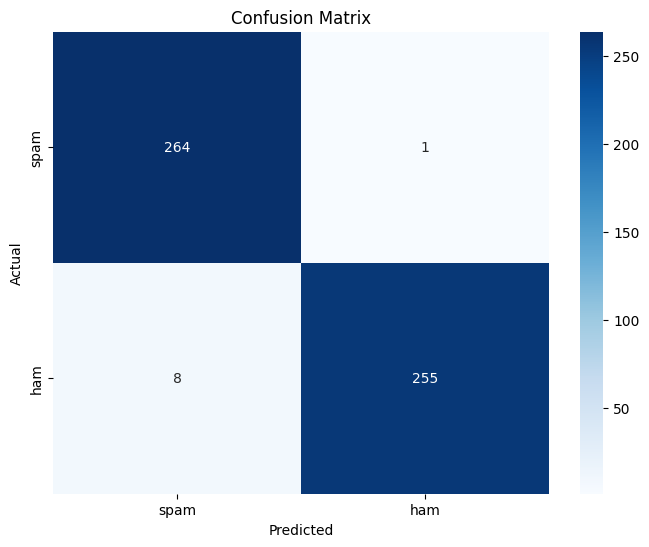


Random Forest Evaluation:
Accuracy: 0.9715909090909091
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       265
           1       0.98      0.96      0.97       263

    accuracy                           0.97       528
   macro avg       0.97      0.97      0.97       528
weighted avg       0.97      0.97      0.97       528



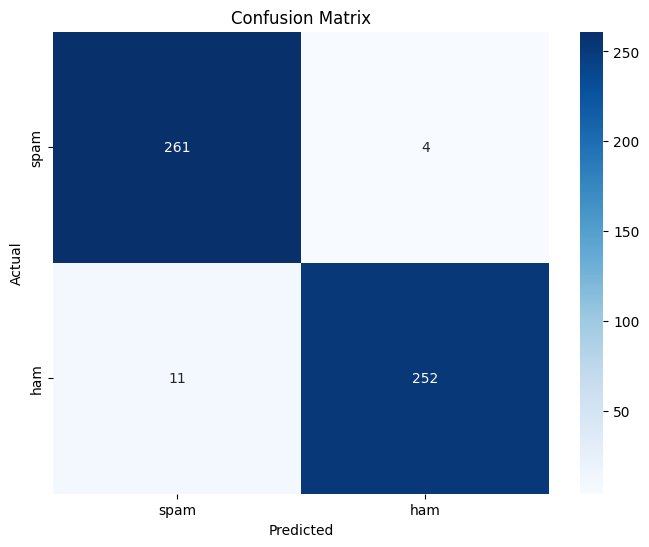

In [76]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, x_test, y_test):
    """Evaluates a given model and prints the results."""
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['spam', 'ham'], yticklabels=['spam', 'ham'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate Naive Bayes
print("Naive Bayes Evaluation:")
evaluate_model(nb_model, x_test, y_test)

# Evaluate Random Forest
print("\nRandom Forest Evaluation:")
evaluate_model(rf_model, x_test, y_test)


## Kurva ROC

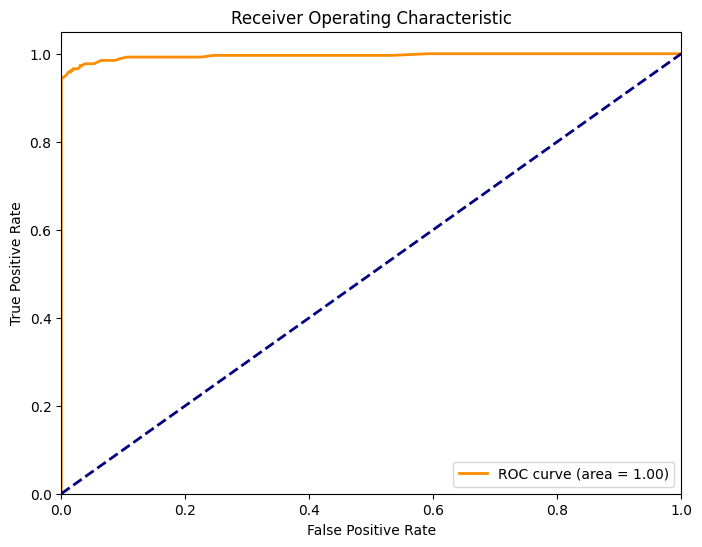

In [77]:
from sklearn.metrics import roc_curve, auc

# Assuming you have your predicted probabilities for the positive class
# For example, using the Random Forest model:
rf_probs = rf_model.predict_proba(x_test)[:, 1]  # Probability of being 'spam' (class 0)


# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Simpan model

In [82]:
import pickle

# menyimpan model
pickle.dump(nb_model,open("model_spam.sav", "wb"))

Berikut adalah identifikasi kesalahan, analisis feature importance, dan rekomendasi perbaikan kontekstual berdasarkan confusion matrix yang Anda tampilkan:

---

### 📌 **1. Identifikasi Kesalahan Utama:**
Dari confusion matrix:
- **False Positives (FP):** 11 pesan ham salah diklasifikasikan sebagai spam.
- **False Negatives (FN):** 4 pesan spam salah diklasifikasikan sebagai ham.

➡️ **Kesalahan utama ada pada False Positives**, yaitu model terlalu sensitif dan menganggap beberapa pesan normal sebagai spam.

---

### 📊 **2. Analisis Feature Importance / Coefficients:**
Jika Anda menggunakan model seperti **Naive Bayes** atau **Logistic Regression**, Anda bisa melihat feature importance atau koefisien dari fitur (kata-kata) dalam model.

- Ciri umum dari **False Positives**: kata-kata seperti "gratis", "penawaran", atau angka besar bisa muncul juga dalam pesan biasa (ham), apalagi jika digunakan dalam konteks yang sah.
- Ciri umum dari **False Negatives**: spam yang disusun dengan bahasa yang mirip percakapan normal bisa lolos klasifikasi.

➡️ Kata-kata yang terlalu umum atau ambigu bisa memberi bobot besar pada prediksi, padahal konteksnya tidak selalu mengindikasikan spam.

---

### ✅ **3. Rekomendasi Perbaikan Kontekstual:**

#### a. **Gunakan N-grams (bi-gram/trigram):**
Agar model memahami frasa seperti "penawaran menarik" atau "klik di sini", yang lebih representatif dibanding kata tunggal seperti “penawaran”.

#### b. **Perluas Preprocessing:**
- Perhatikan **stopwords**, **stemming**, dan **tokenization**.  
- Pertimbangkan konteks emotikon, tanda baca, atau URL sebagai fitur penting.

#### c. **Tuning Threshold:**
Model Anda mungkin memakai default threshold 0.5. Anda bisa coba **menaikkan threshold** untuk mengurangi False Positive, misalnya ke 0.55–0.6, jika lebih baik untuk konteks Anda.

#### d. **Gunakan Model Tambahan / Ensemble:**
Misalnya kombinasi Naive Bayes + Random Forest atau menggunakan model seperti **XGBoost** untuk meningkatkan akurasi pada kasus-kasus sulit.

#### e. **Analisis Data Salah Prediksi Secara Manual:**
Ambil 5–10 sampel pesan yang salah prediksi → cari pola kesalahan → gunakan untuk membuat **aturan tambahan** atau **fitur baru**.

---

Kalau Anda punya data feature importance dari model Anda, saya bisa bantu menginterpretasikannya lebih dalam. Mau lanjut ke sana?